# Problem Statement : Sentiment Analysis of Real-time Flipkart Product Reviews


In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer , LancasterStemmer , SnowballStemmer , WordNetLemmatizer
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.pipeline import Pipeline,make_pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
import pickle

from wordcloud import WordCloud


from sklearn.metrics import accuracy_score,classification_report,f1_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#Removing "not"  from stopwords
stp=stopwords.words("english")
stp.remove("not")

In [3]:
#Import dataset
data=pd.read_csv(r"C:\Users\LENOVO\Documents\today\reviews_badminton\data.csv")

In [4]:
data1=data.copy()

In [5]:
#Data
data1.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


# Exploratory Data Analysis

In [6]:
data1.shape

(8518, 8)

Data consists of 8518 data points and 8 attributes

In [7]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [8]:
#Find the presence of null values
data1.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [9]:
#Handling null values
data1["Month"]=data1["Month"].astype("string")
data1["Month"]=data1["Month"].fillna("NA NA") 

In [10]:
data1=data1.dropna()

In [11]:
data1["difference in upvotes and downvotes"]=data1["Up Votes"]-data1["Down Votes"]

In [12]:
data1.describe()

,Up Votes,Down Votes,Ratings,difference in upvotes and downvotes
count,8468.000000,8468.000000,8468.000000,8468.000000
mean,0.370690,0.117029,4.186585,0.253661
std,11.530363,3.243640,1.257043,9.827502
min,0.000000,0.000000,1.000000,-4.000000
25%,0.000000,0.000000,4.000000,0.000000
50%,0.000000,0.000000,5.000000,0.000000
75%,0.000000,0.000000,5.000000,0.000000
max,889.000000,219.000000,5.000000,825.000000


In [13]:
#Extract month and year of product reviewed
def extract_month_and_year(input_string):
    parts = input_string.split()
    year = parts[-1]
    month = ' '.join(parts[:-1])
    return month, year

data1[['month', 'year']] = data1['Month'].apply(lambda x: pd.Series(extract_month_and_year(x)))



In [14]:
data1.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings,difference in upvotes and downvotes,month,year
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4,825.0,Feb,2021
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1,103.0,Feb,2021
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1,39.0,Apr,2021
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NA NA,"Quite O. K. , but nowadays the quality of the...",3,24.0,NA,NA
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.READ MORE,5,128.0,Oct,2018


In [15]:
len(data1[data1["difference in upvotes and downvotes"]<0])

53

In [16]:
#dropping reviews that are having negative difference
data1=data1.loc[data1["difference in upvotes and downvotes"]>=0]

In [17]:
data1.shape

(8415, 11)

Since there is a conflict in the review of the product and their upvotes and downvotes. Those reviews are dropped and 
the number of reviews dropped are 53

In [18]:
data1["month"].value_counts()

Oct    846
Dec    763
Jan    735
Nov    675
Mar    662
May    649
Feb    628
Aug    626
Sep    622
Jun    619
Jul    619
Apr    517
NA     454
Name: month, dtype: int64

Product was reviewedin all the months. We can consider that product was purchased in all months irrespective of holidays.😜

In [19]:
#Place of review
data1["Place of Review"].value_counts()

Certified Buyer, Bengaluru             318
Certified Buyer, Hyderabad             248
Certified Buyer, Chennai               239
Certified Buyer, Bangalore             211
Certified Buyer, New Delhi             154
                                      ... 
Certified Buyer, Kuttiattoor             1
Certified Buyer, Chandauli District      1
Certified Buyer, Dhubri District         1
Certified Buyer, Kathanian               1
Certified Buyer, Raebareli               1
Name: Place of Review, Length: 2326, dtype: int64

In [20]:
#Extract Place from "Place Of Review"
def city(input_string):
    parts = input_string.split(", ")
    city = parts[-1]
    return city

data1[["city"]] = data1['Place of Review'].apply(lambda x: pd.Series(city(x)))

In [21]:
#To remove district from city
def city1(input_string):
    parts = input_string.split()
    city1 = parts[0]
    return city1


In [22]:
#Data manipulation of "City"
def replace_city(val):
    val = val.lower()
    if  ('bang' in val) or ("beng" in val) :
        return 'Bengaluru'
    elif 'hyd' in val :
        return 'Hyderabad'
    elif 'mang' in val:
        return 'Mangalore'
    elif "district" in val:
        return  city1(val).capitalize()
    else:
        return val.capitalize()

In [23]:
data1["city"]=data1["city"].apply(replace_city)

In [24]:
data1["city"].nunique()

2064

The reviewer of the product are from 2064 unique cities

In [25]:
data1["Reviewer Name"].value_counts()

Flipkart Customer    2076
My Account             11
Praveen Kumar           6
Santhosh Kumar          5
Rajesh Kumar            5
                     ... 
Aayushya Shukla         1
RAMAKRISHNA GOTLA       1
Md intaz Sk             1
MANOHAR PAIGHAN         1
Jayachandra             1
Name: Reviewer Name, Length: 6176, dtype: int64

Though the reviewer name is same, we cannot consider it for dropping or cleaning as it doesn't make any sense for the problem statement

In [26]:
#Review_text
data1["Review text"]=   data1["Review text"].apply(lambda x : re.sub("READ MORE"," ",x))

The review text is having "READ MORE" for every review ,  replaced it with " "

In [27]:
data1["Review text"]

0       Nice product, good quality, but price is now r...
1       They didn't supplied Yonex Mavis 350. Outside ...
2       Worst product. Damaged shuttlecocks packed in ...
3       Quite O. K. , but nowadays  the quality of the...
5               Good quality product. Delivered on time. 
                              ...                        
8494                            Excellent quick delivery 
8495    Thanks to the delivery boy ... Service is alwa...
8496    Over priced even after 50% discount price is m...
8497    Too much priced. It was getting me for Rs. 640...
8499    Hii flipkart customers care..why your delivery...
Name: Review text, Length: 8415, dtype: object

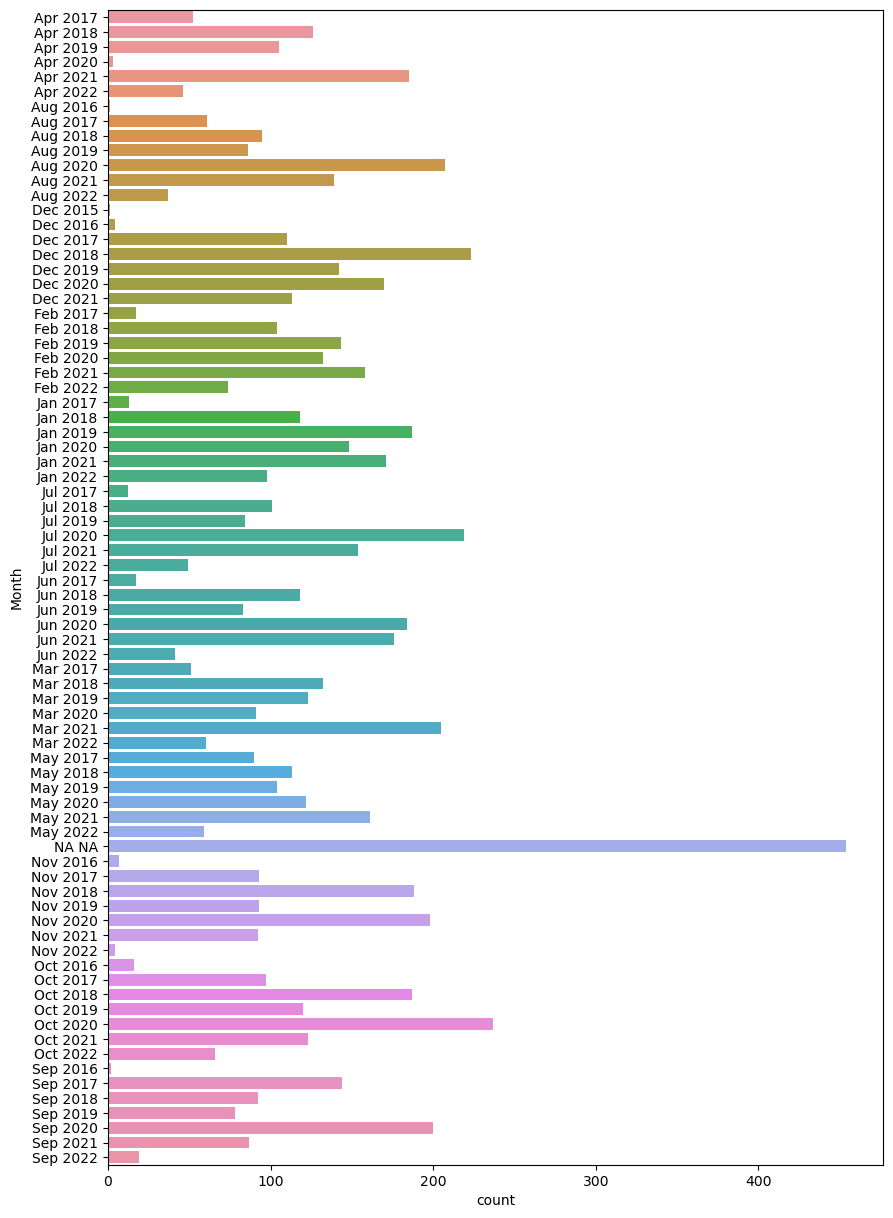

In [28]:
plt.figure(figsize=(10,15))
sns.countplot(data=data1,y="Month",order=data1["Month"].value_counts().index.sort_values())
plt.show()

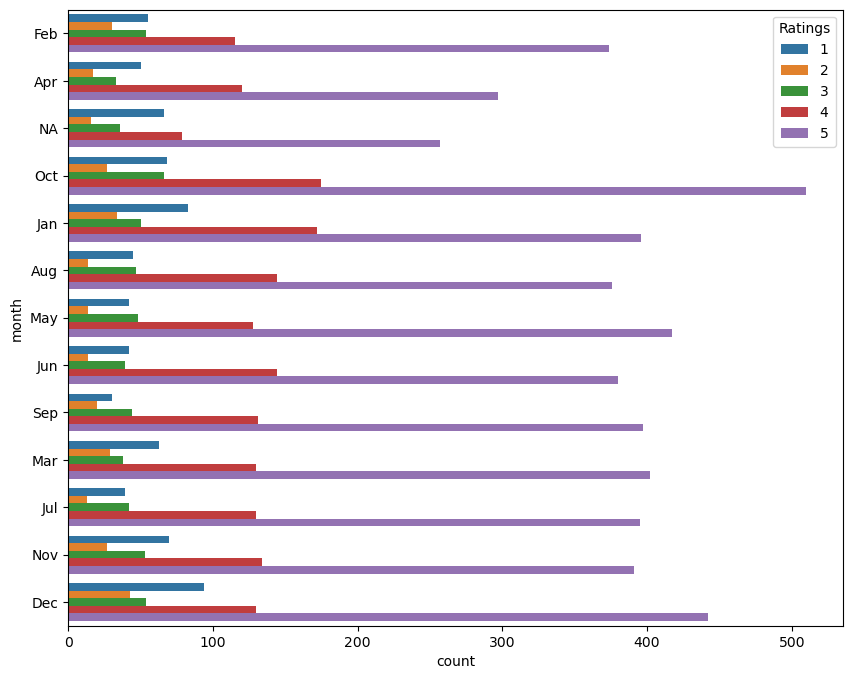

In [29]:
plt.figure(figsize=(10,8))
sns.countplot(data=data1,y="month",hue="Ratings")
plt.show()

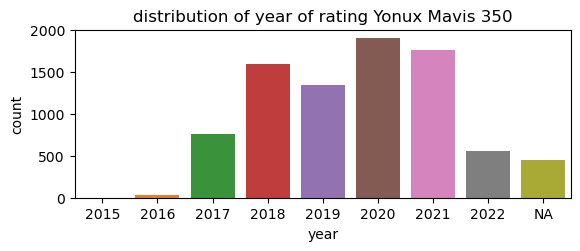

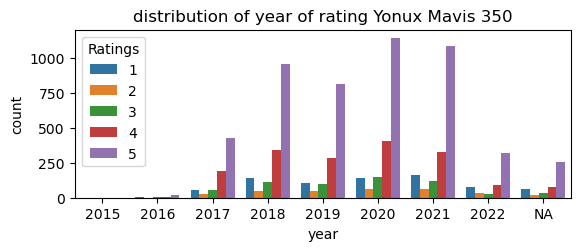

In [30]:
plt.subplot(211)
sns.countplot(data=data1,x="year",order=data1["year"].value_counts().index.sort_values())
plt.title("distribution of year of rating Yonux Mavis 350")
plt.show()

plt.subplot(212)

sns.countplot(data=data1,x="year",order=data1["year"].value_counts().index.sort_values(),hue="Ratings")
plt.title("distribution of year of rating Yonux Mavis 350")
plt.show()

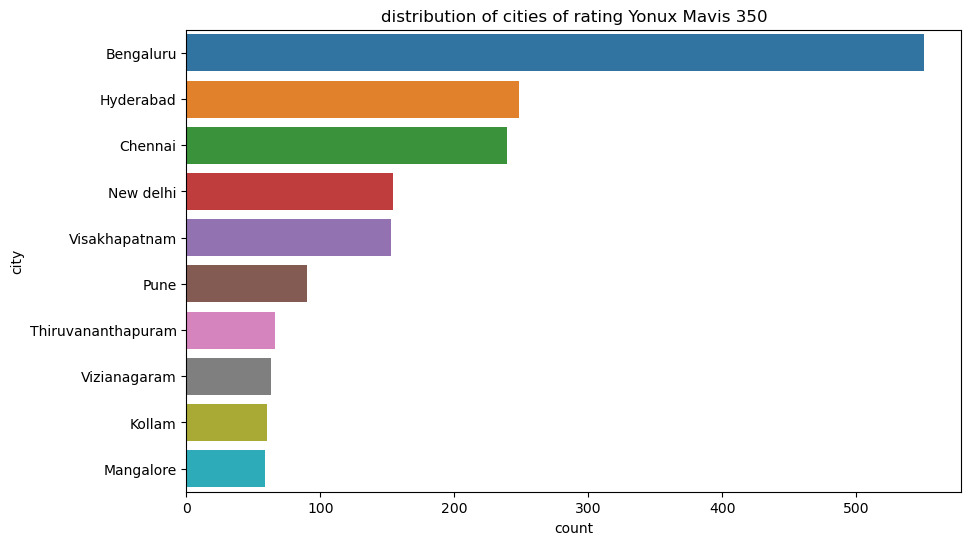

In [31]:
plt.figure(figsize=(10,6))
sns.countplot(data=data1,y="city",order=data1["city"].value_counts().index[:10])
plt.title("distribution of cities of rating Yonux Mavis 350")
plt.show()

"Bengaluru" is the city where "Yonux Mavis 350" was mostly reviewed from , followed by Hyderabad , Chennai , New Delhi , and Mangalore 
is the 10th city.

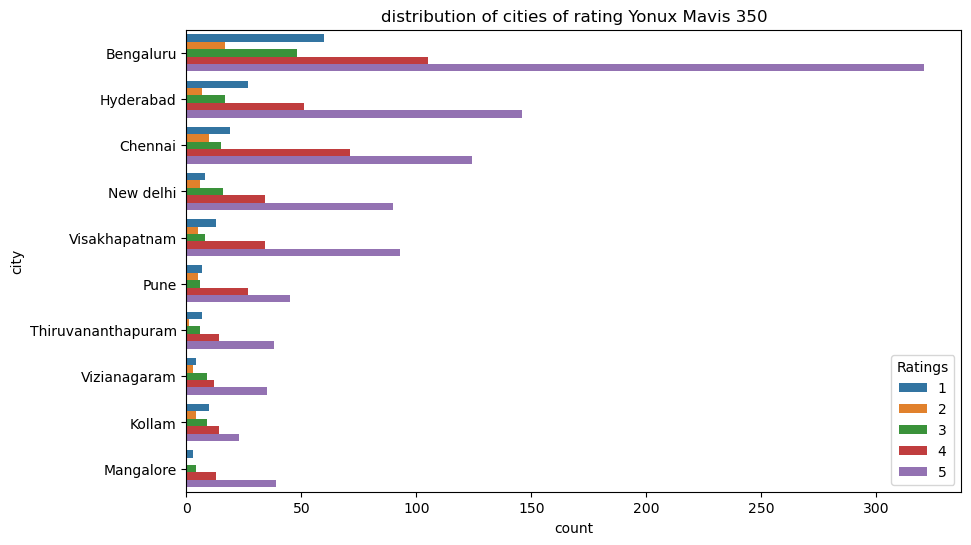

In [32]:
plt.figure(figsize=(10,6))
sns.countplot(data=data1,y="city",order=data1["city"].value_counts().index[:10],hue="Ratings")
plt.title("distribution of cities of rating Yonux Mavis 350")
plt.show()

From all the cities , the product is mostly reviewed as 5 and 4 . As per the analysis the product is a good product yet let's dive deep

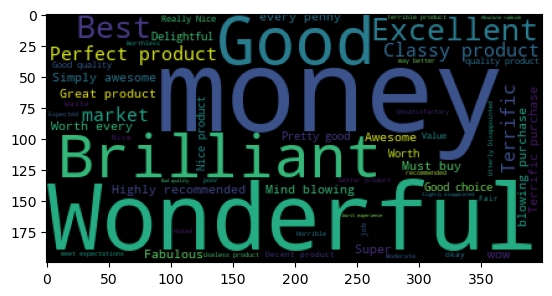

In [33]:
#Wordcloud 
from wordcloud import WordCloud
text=" ".join(i for i in data1["Review Title"])
wordcloud=WordCloud().generate(text)
plt.imshow(wordcloud)
plt.show()

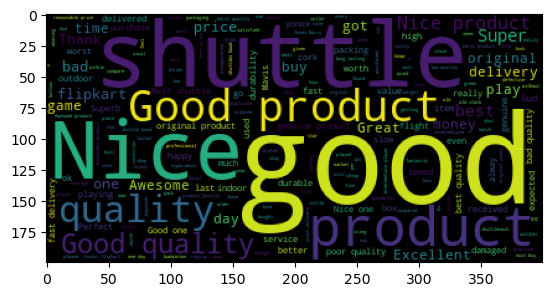

In [34]:
text=" ".join(i for i in data1["Review text"])
wordcloud=WordCloud().generate(text)
plt.imshow(wordcloud)
plt.show()

In [35]:
#Grouping the data by emotion
grp=data1.groupby("Ratings")

In [36]:
#MOst frequent words of rating "1"
Counter(" ".join(grp.get_group(1)["Review text"]).split()).most_common(10)

[('quality', 170),
 ('the', 167),
 ('is', 165),
 ('not', 164),
 ('product', 158),
 ('of', 117),
 ('bad', 113),
 ('very', 104),
 ('Very', 97),
 ('shuttle', 96)]

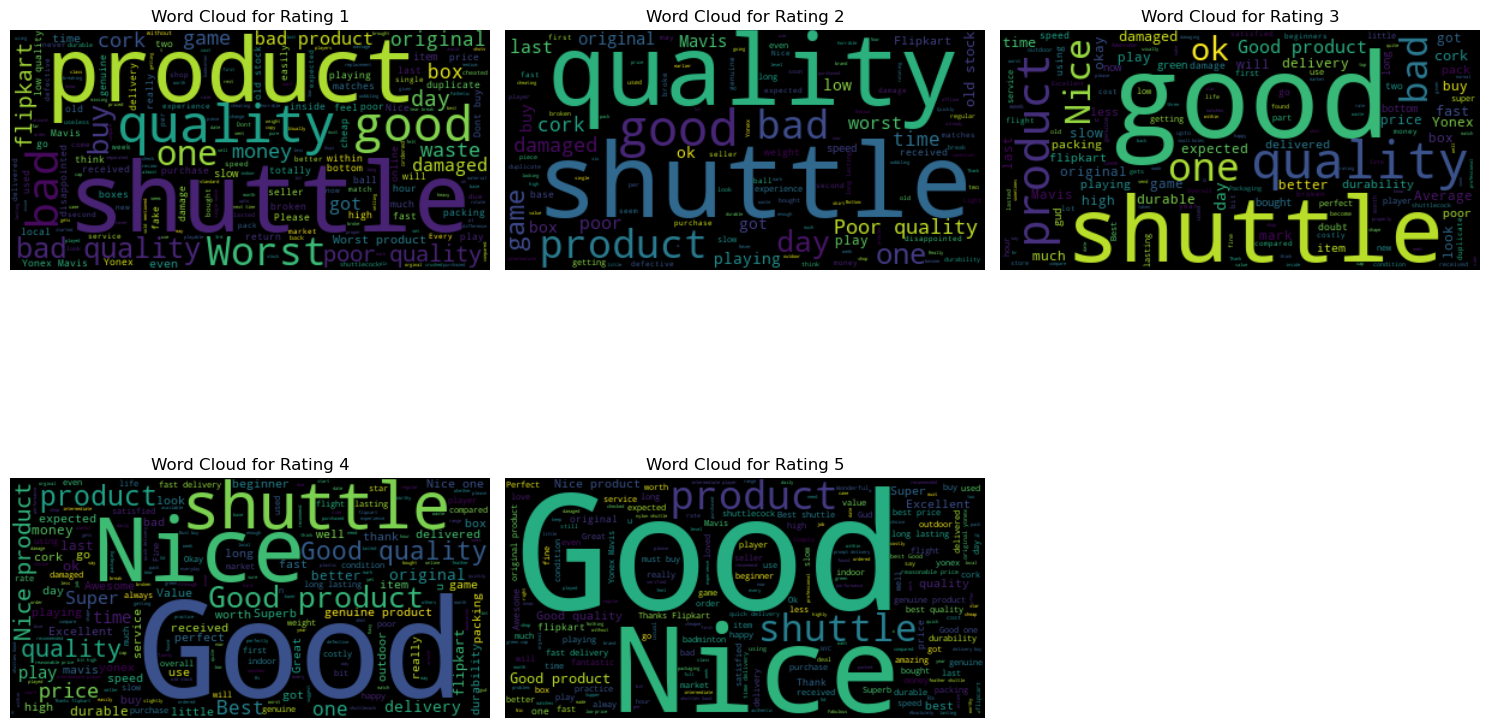

In [37]:
plt.figure(figsize=(15,10))


for i in range(1, 6):
    plt.subplot(2, 3, i)
    text = " ".join(review for review in grp.get_group(i)["Review text"])
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Word Cloud for Rating {}".format(i))
    plt.axis('off')

plt.tight_layout()
plt.show()

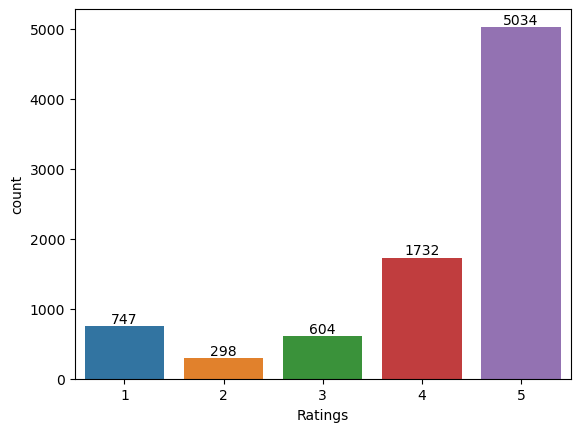

In [38]:
a=sns.countplot(data=data1,x="Ratings")
for i in a.containers:
    a.bar_label(i)

# Feature Engineering 

In [39]:
#Taking the required columns
data2=data1.iloc[:,6:8]

In [40]:
data2.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
5,Good quality product. Delivered on time.,5


In [41]:
data2["Ratings"].value_counts()

5    5034
4    1732
1     747
3     604
2     298
Name: Ratings, dtype: int64

Data set is completely imbalanced dataset

In [42]:
data2["Ratings"]=data2["Ratings"].map({5:"Positive",4:"Positive",3:"Positive",2:"Negative",1:"Negative"})

In [43]:
#Extracting Feature variables and class variables
fv=data2.iloc[:,0]  #feature variable
cv=data2.iloc[:,1]  #class variable

In [44]:
cv=cv.map({"Positive":0,"Negative":1})

In [45]:
#Splitting the data train and test sets
x_train,x_test,y_train,y_test=train_test_split(fv,cv,test_size=0.2,stratify=cv,random_state=5)

In [46]:
#Defining different functions to perform text preprocessing 

In [47]:
def lowers(x):
    return x.str.lower()

In [48]:
def html(x):
    return x.apply(lambda x : re.sub("<.+?>"," ",x))

In [49]:
def url(x):
    return x.apply(lambda x:re.sub("http[s]?://.+? +"," ",x))

In [50]:
def unw(x):
    return x.apply(lambda x:re.sub("[]:()*\-.,@#!'?/$%^&0-9]"," ",x))

In [51]:
def stp1(x):
   l=[]
   for word in word_tokenize(x):

          if word in stp:
             pass
          elif len(word)<=2:
             pass
          else:
            l.append(word)
   return " ".join(l)

In [52]:
def stpp(x):
    return x.apply(lambda x : stp1(x))

In [53]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

In [54]:
def word_pp(x,text_pp):
     if text_pp=="lemma":
        return x.apply(lambda x : lemmatize_text(x))
     elif text_pp=="stem":
        return x.apply(lambda x : stem_text(x))
     else:
        return x
            
        



In [55]:
def handle_negations(text):
    negations = ["not", "no" , "never" ,"n't"]
    for negation in negations:
        text = text.replace(negation + " ", negation + "_")
    return text
def h_nego(x):
    return x.apply(lambda x : handle_negations(x))

In [56]:
#Pipeline to perform Text preprocessing

In [57]:
pre_pro_ppline=Pipeline([("lower",FunctionTransformer(lowers)),("html",FunctionTransformer(html))
                         ,("url",FunctionTransformer(url)),("unw",FunctionTransformer(unw)),
                         ("stp",FunctionTransformer(stpp)),("lem",FunctionTransformer(word_pp, kw_args={"text_pp":"lemma"})),
                        ("hneg",FunctionTransformer(h_nego))])

In [58]:
pre_pro_ppline

Pipeline(steps=[('lower',
                 FunctionTransformer(func=<function lowers at 0x000001E92CF8CEE0>)),
                ('html',
                 FunctionTransformer(func=<function html at 0x000001E92CF8CE50>)),
                ('url',
                 FunctionTransformer(func=<function url at 0x000001E92CF8C280>)),
                ('unw',
                 FunctionTransformer(func=<function unw at 0x000001E92CF8F490>)),
                ('stp',
                 FunctionTransformer(func=<function stpp at 0x000001E92CF8F370>)),
                ('lem',
                 FunctionTransformer(func=<function word_pp at 0x000001E92CF8C550>,
                                     kw_args={'text_pp': 'lemma'})),
                ('hneg',
                 FunctionTransformer(func=<function h_nego at 0x000001E92D497640>))])

In [59]:
#Fit and Transforming x_train
x_train_pp=pre_pro_ppline.fit_transform(x_train)

In [60]:
#Transforming x_test
x_test_pp=pre_pro_ppline.transform(x_test)

In [61]:
import warnings

warnings.filterwarnings('ignore')

In [62]:
pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ]),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ]),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ])
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(x_train_pp, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    #print("Score on Train Data : ",grid_search.score(x_train_pp,y_train))
    
    print('Score on Test Data: ', grid_search.score(x_test_pp, y_test))
    

********** naive_bayes **********
Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: total: 5.09 s
Wall time: 6.43 s
Score on Test Data:  0.7000000000000001
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 30.9 s
Wall time: 41.4 s
Score on Test Data:  0.6224489795918368
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 11min 21s
Wall time: 14min 13s
Score on Test Data:  0.7136563876651982


In [67]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(steps=[('vectorization', CountVectorizer(max_features=1000)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(steps=[('vectorization', TfidfVectorizer(max_features=2000)),
                ('classifier', DecisionTreeClassifier())])

logistic_regression
Pipeline(steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', l1_ratio=0.6,
                                    penalty='elasticnet', solver='saga'))])



In [ ]:
import joblib
import os
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'Best_models1/{name}.pkl')
    model = joblib.load(f'Best_models1/{name}.pkl')
    
    %time y_test_pred = model.predict(x_test_pp)
    print("Test Score (F1)", f1_score(y_test, y_test_pred))
    
    print("Model Size:", os.path.getsize(f'Best_models1/{name}.pkl'), "Bytes")